# **Section 1: Setup and Imports** <a id="1"></a>

## **Importing necessary libraries**

In [1]:
import os
import sys
import uuid
from pathlib import Path
import pandas as pd
from typing import Dict, List
import pytest
import json
from datetime import datetime

## **Import Shared Functions From Project Folder** <a id="1.1"></a>
We will import the shared functions from the project folder that we built for IT Consultant Report Reviewer with ReAct. This is done to keep the notebook clean and organized. The functions are used for data loading, preprocessing, and evaluation.

In [2]:
# ✅ Adjust the path if your notebook is in /notebooks and src/ is a sibling
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root))

# Core OpenAI API
from src.models.openai_interface import call_openai_with_tracking

# ReAct reasoning agent and tools
from src.server.react_agent import (
    ReActConsultantAgent,
    run_react_loop_check_withTool,
    dispatch_tool_action, 
    select_best_tool_with_llm,
    run_react_loop_for_rfp_eval
)

# Proposal orchestration (ToT + ReAct hybrid)
#from src.server.report_review_runner import (
#    summarize_and_score_section
#)

# Prompt builders and tool descriptions
from src.server.prompt_builders import (
    build_tool_hints,
    format_tool_catalog_for_prompt
)

# Proposal scoring and analysis
from src.models.scoring import summarize_and_score_section

# LLM-based section tools (for evaluation scoring)
from src.models.section_tools_llm import (
    should_cite,
    auto_fill_gaps_with_research,
    upgrade_section_with_research,
    make_text_coherent,
    generate_final_summary,
    format_upgraded_sections
)

# File loading utility (later use for multi-proposal)
from src.utils.file_loader import load_scenario_data

# Text processing (optional for parsing requirements/proposals)
#from src.utils.text_processing import (
#    split_report_into_sections,
#    map_section_to_canonical,
#    guess_canonical_section_with_llm
#)

# Visualization (optional for tool analysis)
from src.utils.visualization import (
    print_tool_usage,
    plot_tool_usage
)

# Exporting to markdown + PDF
#from src.utils.export_utils import (
#    export_report_to_markdown,
#    export_report_to_markdown_and_pdf,
#    show_agent_memory
#)

# Basic tool logic
from src.utils.tools.tools_basic import (
    check_guideline_dynamic,
    keyword_match_in_section,
    search_report,
    generate_client_questions
)

# Web tools
from src.utils.tools.tools_web import (
    search_web,
    search_serpapi,
    search_wikipedia,
    search_arxiv,
    should_search_arxiv
)

# NLP tools
from src.utils.tools.tools_nlp import (
    check_for_jargon,
    check_readability,
    analyze_tone_textblob,
    extract_named_entities
)

# Reasoning tools
from src.utils.tools.tools_reasoning import (
    pick_tool_by_intent,
    pick_tool_by_intent_fuzzy,
    categorize_tools_by_priority,
    analyze_math_question,
)

# LLM-based tools (LLM - thought generator)
from src.models.tot_agent import generate_thoughts_openai

from src.utils.tools.tool_embeddings import (
    build_tool_embeddings, 
    suggest_tools_by_embedding
)

from src.models.openai_embeddings import get_openai_embedding

from src.utils.tools.tool_catalog_RFP import tool_catalog

from src.utils.export_utils import export_proposal_report_to_markdown, convert_markdown_to_pdf

from src.server.proposal_eval import evaluate_proposal

from src.server.multi_agent_rfpevalrunner import run_multi_proposal_evaluation

from src.server.final_eval_summary import generate_final_comparison_summary

from src.utils.export_utils import save_markdown_and_pdf

from src.utils.file_loader import load_proposals_from_folder, load_rfp_criteria, load_default_scenario, list_available_scenarios

from src.utils.logging_utils import (
    setup_logging, 
    display_log, 
    log_phase, 
    tool_stats, 
    thought_score_stats, 
    openai_call_counter
)

from src.utils.logging_reports import finalize_evaluation_run

/Users/liammckendry/spacy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Logging setup**

In [3]:
from IPython.core.magic import register_line_magic
import logging

@register_line_magic
def loglevel(level):
    """Set the log level for the ProposalEvaluator logger."""
    logger = logging.getLogger("ProposalEvaluator")
    level = level.upper()
    if level in ("DEBUG", "INFO", "WARNING", "ERROR"):
        logger.setLevel(getattr(logging, level))
        print(f"🔧 Log level set to {level}")
    else:
        print(f"⚠️ Invalid log level: {level}")


In [4]:
# Set up logging
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"logs/eval_run_{timestamp}.log"
logger = setup_logging(log_filename)

# Print log handlers (stream: console/notebook, file: file)
for h in logger.handlers:
    print(f"📎 Handler: {type(h).__name__}")

# Display the log file path
print(Path(log_filename).resolve())

[22:37:29] [INFO] 📌 Logging initialized
[22:37:29] [INFO] 📌 Log file: logs/eval_run_2025-04-02_22-37-29.log


📎 Handler: StreamHandler
📎 Handler: FileHandler
/Users/liammckendry/Project5_IT_Consultant/notebooks/logs/eval_run_2025-04-02_22-37-29.log


In [5]:
%loglevel DEBUG
print(f"Current log level: {logging.getLevelName(logger.level)}")

🔧 Log level set to DEBUG
Current log level: DEBUG


## **Text Embeddings of Tool Catalog** <a id="1.1"></a>
First, we need to load the tool catalog and create text embeddings for each tool. This will allow us to compare the user's query with the tools available in the catalog.

In [6]:
# One-time setup
tool_embeddings = build_tool_embeddings(tool_catalog)


[22:37:29] [INFO] 📌 ✅ Loaded cached tool embeddings.


# **Section 2: Functions** <a id="1"></a>

Only new ones built for RFP Evaluation (ToT+ReACT Hybrid)

In [7]:
def format_evaluation_report(results):
    """
    Purpose:
    Formats a full evaluation report from a list of Tree of Thought (ToT) results into a markdown string.

    Parameters:
    - results (list of dict): A list of evaluation results, where each result is a dictionary containing:
        - criterion (str): The evaluation criterion.
        - score (int): The score assigned to the criterion (1–10).
        - reasoning_path (list of str): The reasoning path (thoughts) generated during the evaluation.

    Workflow:
    1. Initializes a markdown report string with a title.
    2. Iterates through the `results` list:
        - Extracts the criterion, score, and reasoning path for each result.
        - Appends the criterion, score, and reasoning path to the report in markdown format.
        - Accumulates the total score for calculating the average.
    3. Computes the average score across all criteria.
    4. Appends the overall average score to the report.
    5. Returns the formatted markdown report string.

    Returns:
    - str: A markdown-formatted string representing the evaluation report.
    """
    report = "# 📄 Proposal Evaluation Report\n\n"
    total_score = 0

    for result in results:
        criterion = result["criterion"]
        score = result["score"]
        thoughts = result["reasoning_path"]
        total_score += score

        report += f"## {criterion}\n"
        report += f"**Score**: {score}/10\n\n"
        report += "**Reasoning Path:**\n\n"
        for i, t in enumerate(thoughts, 1):
            report += f"{i}. {t}\n\n"
        report += "\n"

    avg_score = round(total_score / len(results), 2)
    report += f"---\n\n**🧾 Overall Average Score:** {avg_score}/10\n"

    return report


In [8]:
def export_report_to_markdown_tot(report_text, filename="proposal_evaluation_report.md"):
    """
    Purpose:
    Exports a Tree of Thought (ToT) evaluation report to a markdown (.md) file.

    Parameters:
    - report_text (str): The content of the evaluation report in markdown format.
    - filename (str): The name of the markdown file to save the report to. Default is "proposal_evaluation_report.md".

    Workflow:
    1. Opens the specified file in write mode with UTF-8 encoding.
    2. Writes the provided `report_text` to the file.
    3. Prints a confirmation message with the file path.

    Returns:
    - None: This function does not return any value. It saves the report to a file.
    """
    with open(filename, "w", encoding="utf-8") as f:
        f.write(report_text)
    print(f"✅ Markdown report saved to: {filename}")


In [9]:
async def export_tot_report_to_markdown_and_pdf(
    report_md_text,
    markdown_file="proposal_evaluation_report.md",
    pdf_file="proposal_evaluation_report.pdf"
):
    """
    Purpose:
    Exports a Tree of Thought (ToT) evaluation report (provided as a markdown string) to both `.md` and `.pdf` formats.

    Parameters:
    - report_md_text (str): The content of the evaluation report in markdown format.
    - markdown_file (str): The name of the markdown file to save the report to. Default is "proposal_evaluation_report.md".
    - pdf_file (str): The name of the PDF file to save the report to. Default is "proposal_evaluation_report.pdf".

    Workflow:
    1. Ensures the output directory exists (`../outputs/` relative to the current working directory).
    2. Saves the markdown content to a `.md` file in the output directory.
    3. Converts the markdown content to HTML using the `markdown` library.
    4. Wraps the HTML content in a basic HTML template with styling.
    5. Saves the HTML content to a temporary `.html` file in the output directory.
    6. Uses Playwright to render the HTML file and export it as a PDF.
    7. Handles any exceptions during the PDF export process and logs an error message if it fails.

    Returns:
    - None: This function does not return any value. It saves the report to `.md` and `.pdf` files in the output directory.
    """


In [10]:
def score_proposal_content_with_llm(proposal, criterion, top_thoughts=None, model="gpt-3.5-turbo"):
    """
    Purpose:
    Scores how well the proposal meets a specific RFP criterion, optionally guided by Tree of Thought (ToT) thoughts.

    Parameters:
    - proposal (str): The text of the vendor proposal being evaluated.
    - criterion (str): The evaluation criterion against which the proposal is being assessed.
    - top_thoughts (list of str, optional): A list of key thoughts or considerations generated during the evaluation process. Default is None.
    - model (str): The name of the OpenAI model to use for scoring. Default is "gpt-3.5-turbo".

    Workflow:
    1. Constructs a prompt that includes the proposal text, evaluation criterion, and optionally, key thoughts.
    2. Sends the prompt to the OpenAI API using the `call_openai_with_tracking` function.
    3. Parses the response to extract the score and explanation.
    4. If parsing fails, defaults to a fallback score of 5 and a generic explanation.

    Returns:
    - tuple: A tuple containing:
        - score (int): The score assigned to the proposal, ranging from 1 to 10.
        - explanation (str): The reasoning behind the assigned score.
    """
    thoughts_text = ""
    if top_thoughts:
        thoughts_text = "\nHere are some important considerations:\n" + "\n".join(f"- {t}" for t in top_thoughts)

    prompt = f"""
You are evaluating a vendor proposal on the criterion: **{criterion}**.

Proposal:
\"\"\"
{proposal}
\"\"\"
{thoughts_text}

Based on the proposal and the evaluation criteria above, assign a score from 1 to 10.

Respond in this format:
Score: X
Explanation: (why this score)
"""

    messages = [{"role": "user", "content": prompt}]
    response = call_openai_with_tracking(messages, model=model, temperature=0)

    try:
        lines = response.strip().split("\n")
        score_line = next((l for l in lines if "Score:" in l), "Score: 5")
        explanation = next((l for l in lines if "Explanation:" in l), "Explanation: No explanation found.")
        score = int(score_line.split(":")[1].strip())
        explanation = explanation.split(":", 1)[1].strip()
        return score, explanation
    except Exception as e:
        print(f"⚠️ Failed to parse score: {str(e)}")
        return 5, "Failed to parse explanation"


In [11]:
def print_proposal_evaluation(results, overall_score, swot_summary):
    """
    Nicely prints the full evaluation for a proposal, including:
    - Criterion-level scores and reasoning
    - ToT thoughts
    - Tools used and results
    - Final overall score
    - SWOT summary
    """
    print("\n====================")
    print("📊 PROPOSAL EVALUATION")
    print("====================\n")

    for result in results:
        print(f"🔹 Criterion: {result['criterion']}")
        print(f"📈 Score: {result['proposal_score']}/10")
        print(f"🧠 Thoughts:")
        for t in result["reasoning_path"]:
            print(f"   • {t}")
        print("🛠️ Tools Used:")
        for tool in result["triggered_tools"]:
            print(f"   • {tool['tool']}: {tool['result']}")
        print(f"🗣️ Explanation: {result['proposal_explanation']}")
        print("\n--------------------\n")

    print(f"✅ OVERALL SCORE: {overall_score}/10\n")
    print("📋 SWOT ASSESSMENT:\n")
    print(swot_summary)
    print("\n====================\n")


# **Section 3: Load RFP Data** <a id="3"></a>

In [12]:
# --- Use Case ---
use_case = """
A public sector organization is seeking a new cloud-based Electronic Health Record (EHR) system. 
They've issued an RFP to multiple technology vendors. Each proposal must address:
- Functional fit to healthcare workflows
- Technical architecture
- Cost structure
- Implementation timeline
- Vendor experience
- Risk management

As a first step, we want our AI agent to evaluate a single proposal using Tree of Thought reasoning.
"""

# --- Evaluation Criteria ---
rfp_criteria = [
    "Solution Fit",
    "Technical Architecture",
    "Cost",
    "Implementation Timeline",
    "Vendor Experience",
    "Risk Management",
]



In [13]:
rfp_path = "../data/rfps/sample_rfp.txt"
rfp_criteria = load_rfp_criteria(rfp_path)
print("✅ RFP Criteria Loaded:")
print(rfp_criteria)


✅ RFP Criteria Loaded:
['Request for Proposals – Evaluation Criteria for Electronic Health Record (EHR) Modernization', 'Proposals will be assessed on both qualitative and quantitative measures. Each criterion is weighted equally unless otherwise noted.', 'Solution Fit', 'This includes configurability, modularity, clinical workflow alignment, and support for both primary and specialty care.', 'Technical Architecture', 'g., HL7/FHIR), security, performance, and alignment with industry best practices for healthcare IT.', 'Cost', 'Transparency of pricing model, scalability of costs, and any hidden fees will be reviewed.', 'Implementation Timeline', 'Consideration will be given to vendor capacity, risk mitigation strategies, and past delivery performance.', 'Vendor Experience', 'References, case studies, certifications, and qualifications of key team members will be taken into account.', 'Risk Management', 'g., HIPAA/PHIPA), system availability, and vendor lock-in. Proposals should include

In [14]:
# Load proposals from folder
dummy_proposals = load_proposals_from_folder("../data/proposals/")

print(f"Loaded {len(dummy_proposals)} proposals.")
print(dummy_proposals)

Loaded 0 proposals.
{}


In [15]:
rfp_path = "../data/rfps/sample_rfp.txt"
rfp_criteria = load_rfp_criteria(rfp_path)
print("✅ RFP Criteria Loaded:")
print(rfp_criteria)

✅ RFP Criteria Loaded:
['Request for Proposals – Evaluation Criteria for Electronic Health Record (EHR) Modernization', 'Proposals will be assessed on both qualitative and quantitative measures. Each criterion is weighted equally unless otherwise noted.', 'Solution Fit', 'This includes configurability, modularity, clinical workflow alignment, and support for both primary and specialty care.', 'Technical Architecture', 'g., HL7/FHIR), security, performance, and alignment with industry best practices for healthcare IT.', 'Cost', 'Transparency of pricing model, scalability of costs, and any hidden fees will be reviewed.', 'Implementation Timeline', 'Consideration will be given to vendor capacity, risk mitigation strategies, and past delivery performance.', 'Vendor Experience', 'References, case studies, certifications, and qualifications of key team members will be taken into account.', 'Risk Management', 'g., HIPAA/PHIPA), system availability, and vendor lock-in. Proposals should include

# **Section 4: Single Agent - Evaluate One Proposal** <a id="4"></a>
**Run Hybrid ToT + ReAct Model**

In [16]:
# Step 1: Run evaluation for single proposal
execute_cell = False

if execute_cell:
    results_a, overall_score_a, swot_summary_a = evaluate_proposal(proposal_a, rfp_criteria)
else:
    print("⚠️ Execution skipped. Set `execute_cell = True` to run this cell.")

⚠️ Execution skipped. Set `execute_cell = True` to run this cell.


In [17]:
execute_cell = False

if execute_cell:
    # Print single proposal report after getting results:
    md_path = export_proposal_report_to_markdown(results_a, overall_score_a, swot_summary_a, proposal_name="VendorA")
    pdf_path = convert_markdown_to_pdf(md_path)

    print(f"✅ Saved: {md_path}")
    print(f"✅ Saved: {pdf_path}")
else:
    print("⚠️ Execution skipped. Set `execute_cell = True` to run this cell.")


⚠️ Execution skipped. Set `execute_cell = True` to run this cell.


# **Section 5: Multi-Agent - Evaluate Multiple Proposals** <a id="5"></a>
**Display Evaluation Metrics & Export to MD, HTML and PDF**

In [18]:
scenarios = list_available_scenarios()
print("Available rfp scenarios:", scenarios)

Available rfp scenarios: ['scenario1_basic', 'scenario2_realistic']


[22:37:29] [INFO] 📌 📁 Loading scenario: scenario1_basic
[22:37:29] [INFO] 📌 📁 Loading scenario data from /Users/liammckendry/Project5_IT_Consultant/data/rfp_scenarios/scenario1_basic (RFP: /Users/liammckendry/Project5_IT_Consultant/data/rfp_scenarios/scenario1_basic/rfp.txt)
[22:37:29] [INFO] 📌 📄 Found 3 files
[22:37:29] [INFO] 📌 📄 Loading proposal from rfp.txt
[22:37:29] [INFO] 📌 📄 Loading proposal from vendor_b.txt
[22:37:29] [INFO] 📌 📄 Loaded proposal for Vendor B
[22:37:29] [INFO] 📌 📄 Loading proposal from vendor_a.txt
[22:37:29] [INFO] 📌 📄 Loaded proposal for Vendor A
[22:37:29] [INFO] 📌 ✅ Loaded 2 proposals and RFP from /Users/liammckendry/Project5_IT_Consultant/data/rfp_scenarios/scenario1_basic/rfp.txt
[22:37:29] [INFO] 📌 📄 Loading RFP from /Users/liammckendry/Project5_IT_Consultant/data/rfp_scenarios/scenario1_basic/rfp.txt...
[22:37:29] [INFO] 📌 ✅ RFP loaded. Extracted full_text: Evaluation Criteria:
1. Solution Fit
2. Cost

[22:37:29] [INFO] 📌 ✅ Extracted RFP sections: {'Eva

✅ Saved: /Users/liammckendry/Project5_IT_Consultant/outputs/proposal_eval_reports/final_summary_report.md, /Users/liammckendry/Project5_IT_Consultant/outputs/proposal_eval_reports/final_summary_report.html, /Users/liammckendry/Project5_IT_Consultant/outputs/proposal_eval_reports/final_summary_report.pdf


/Users/liammckendry/Project5_IT_Consultant/src/utils/reasoning_lineage.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

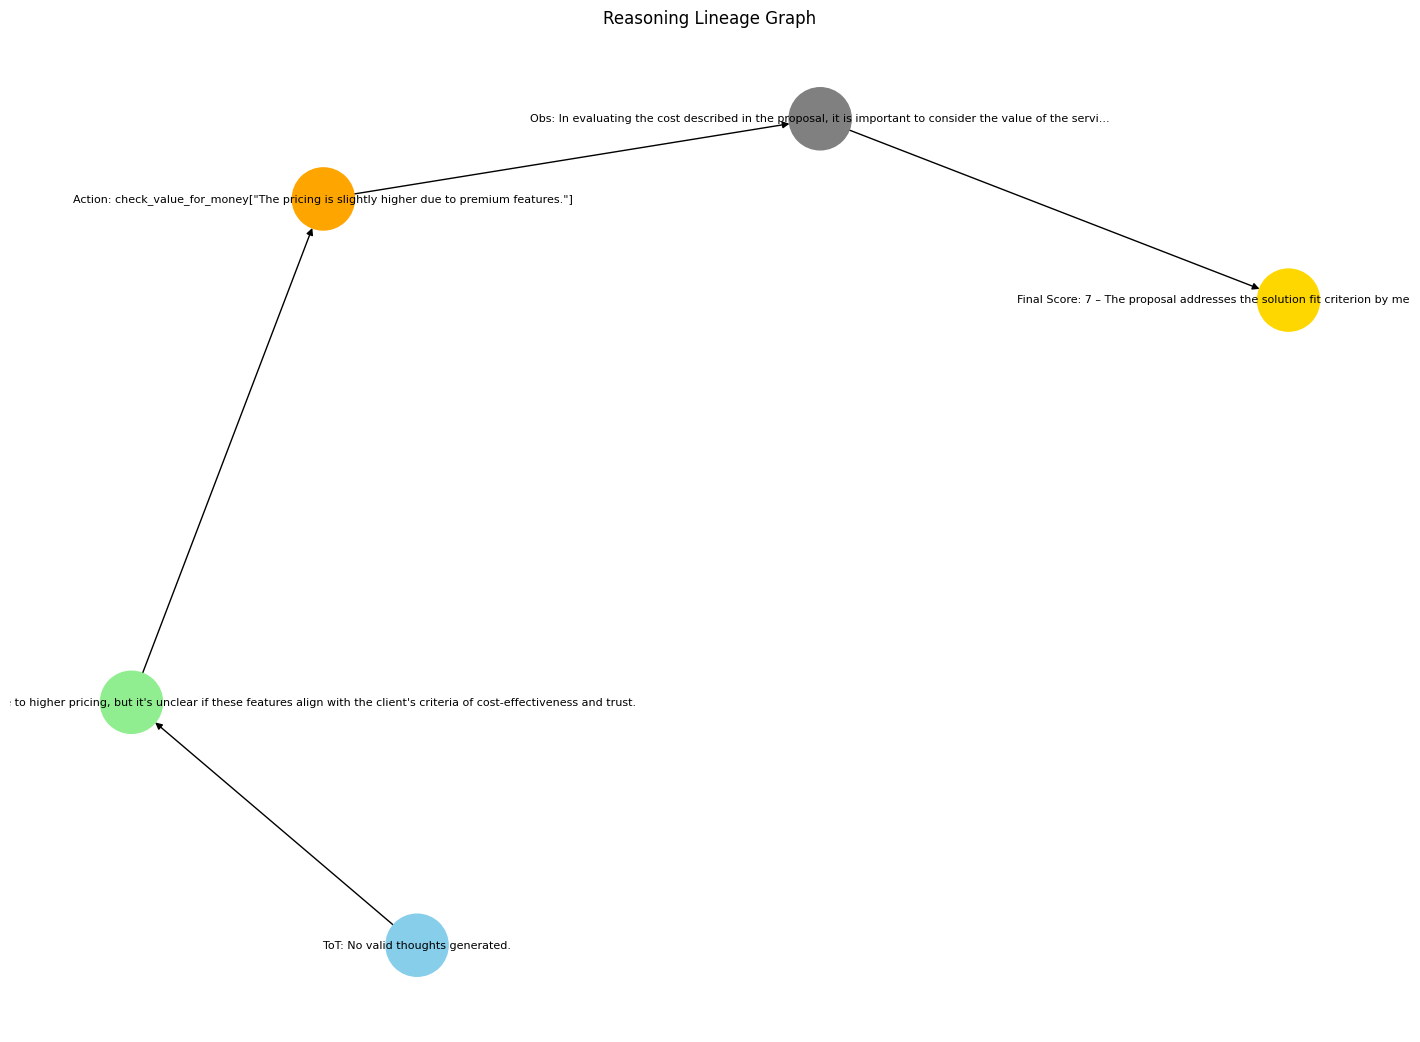

<Figure size 640x480 with 0 Axes>

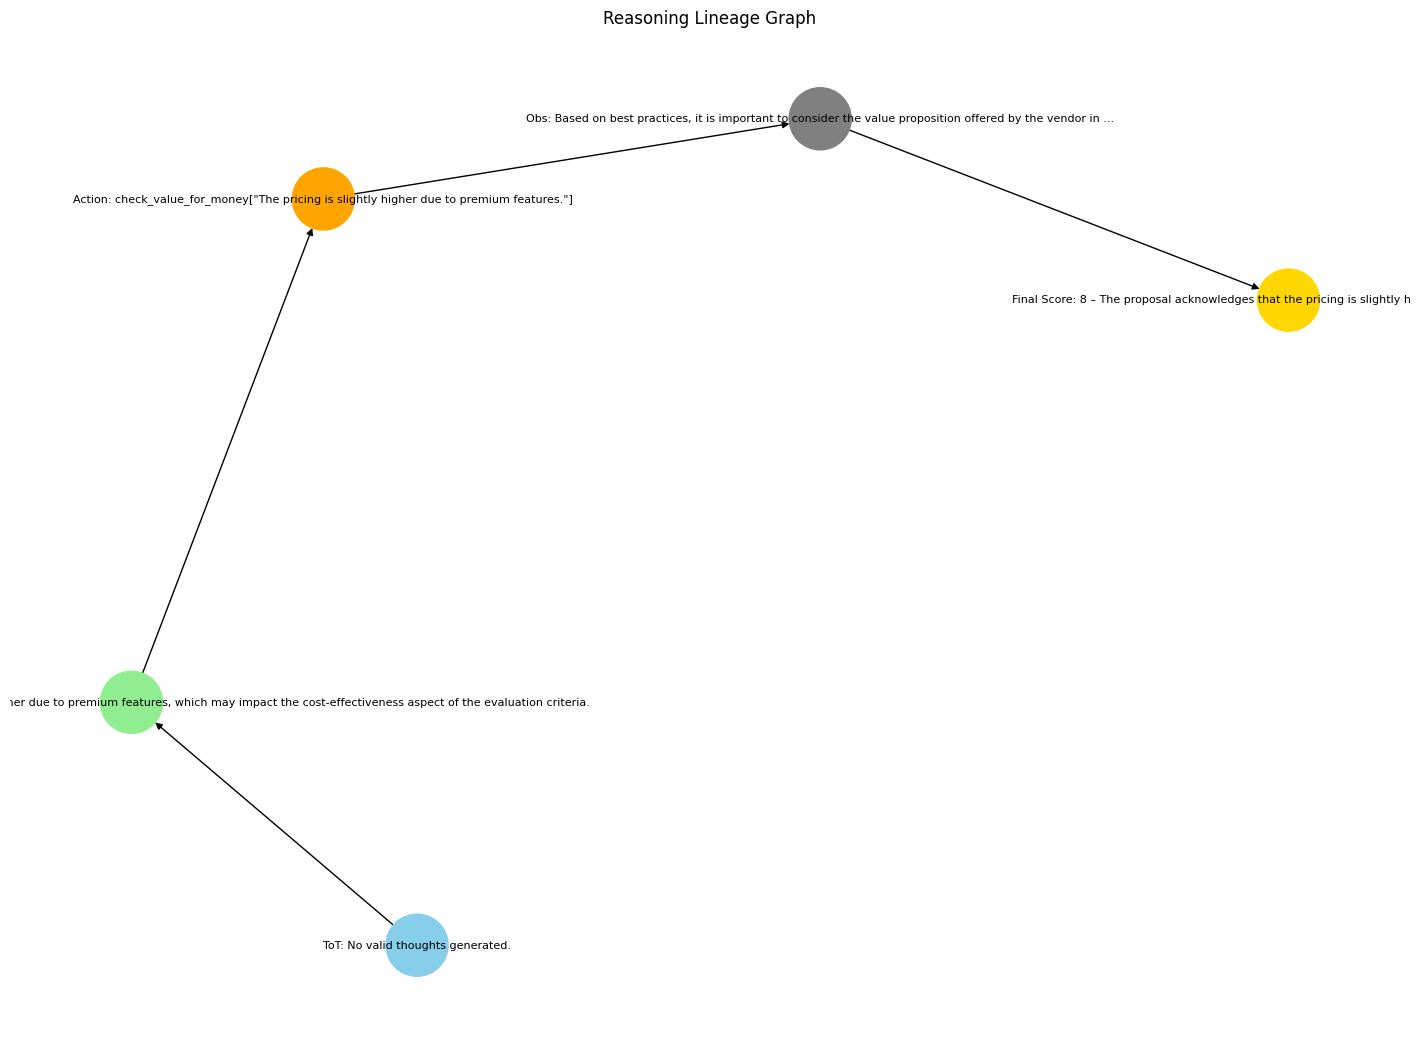

<Figure size 640x480 with 0 Axes>

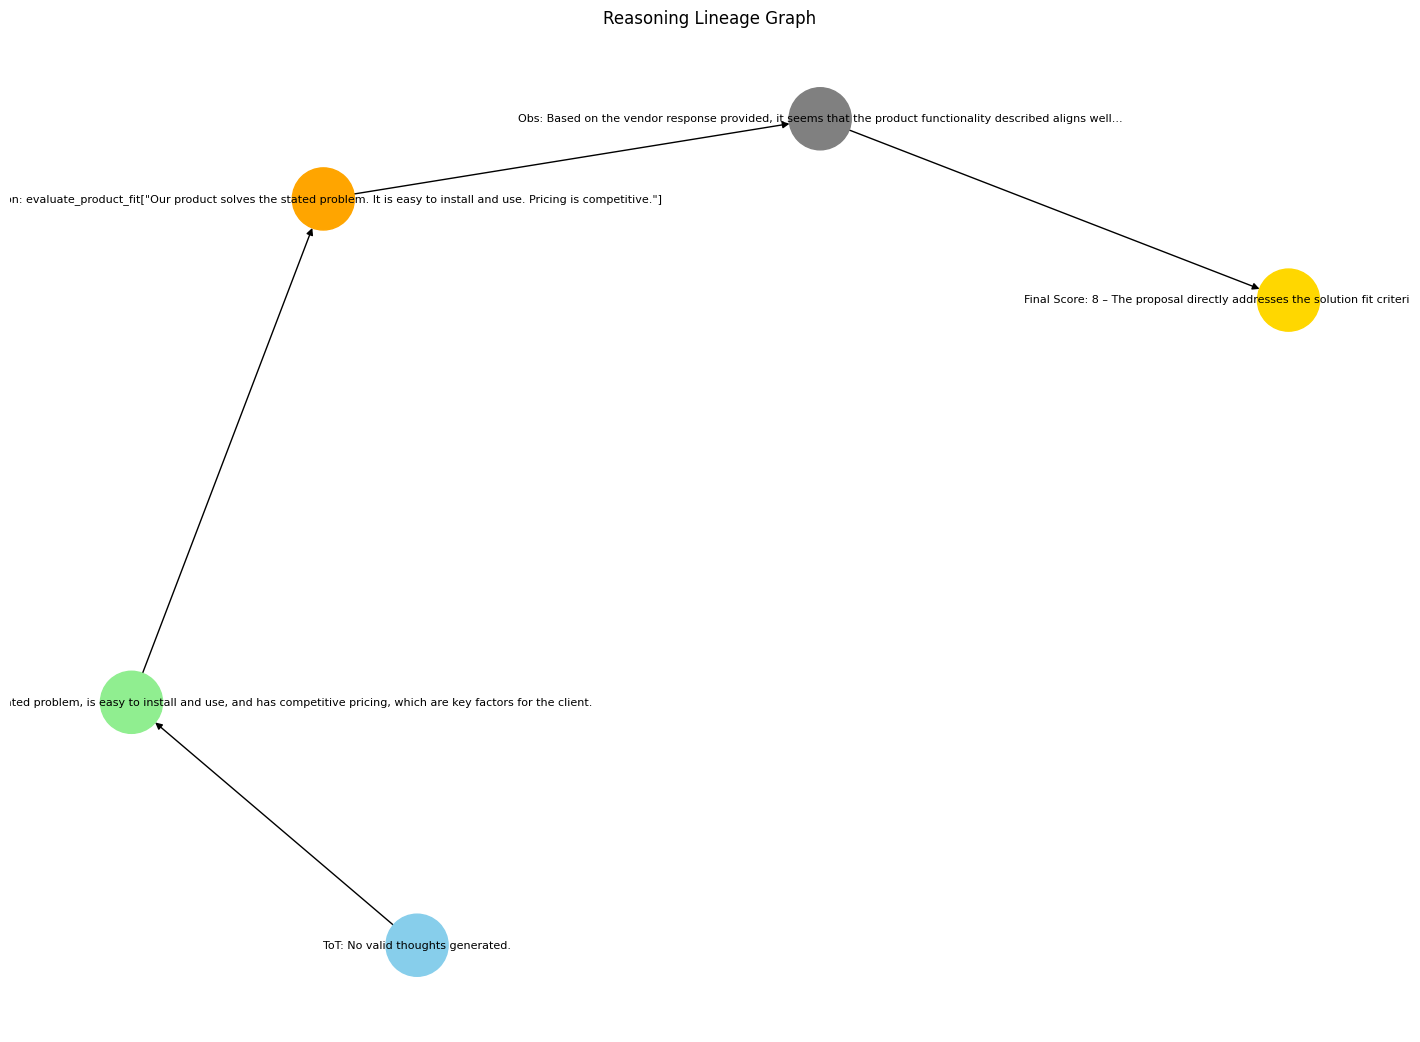

<Figure size 640x480 with 0 Axes>

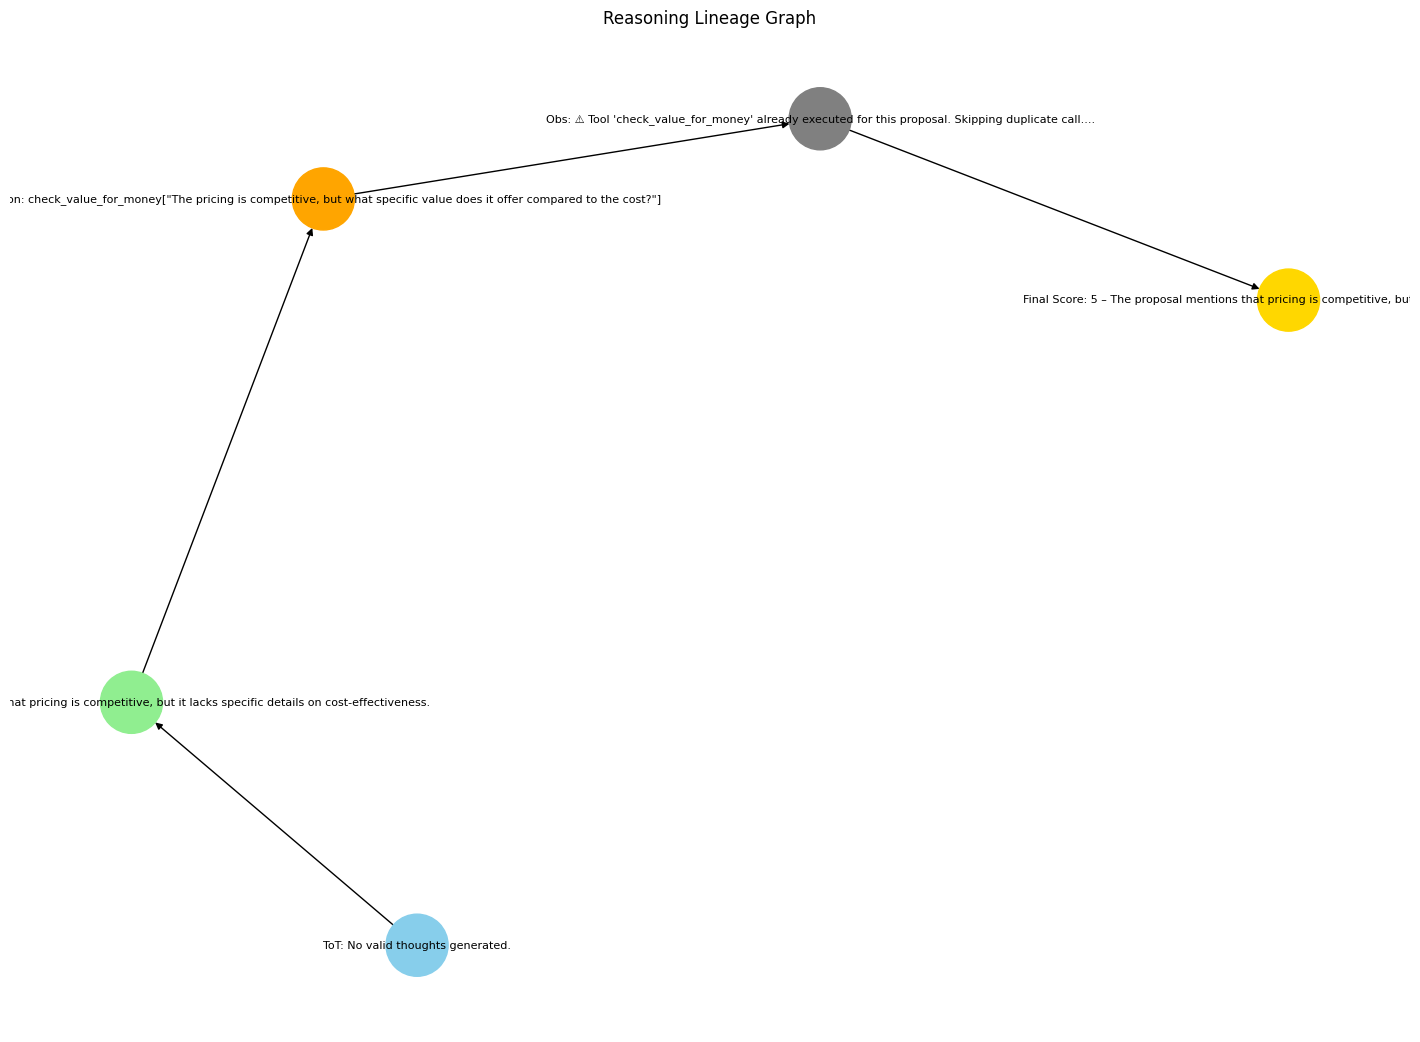

[22:38:49] [INFO] 📌 ✅ Log summary and analysis report written.
[22:38:49] [INFO] 📌 ✅ Multi-proposal evaluation completed.
[22:38:49] [INFO] 📌 ✅ Log report saved to: logs/eval_summary_2025-04-02_22-38-47.md
[22:38:49] [INFO] 📌 ✅ All vendor evaluations saved to: ../outputs/proposal_eval_reports/all_vendor_evaluations.json
[22:38:49] [INFO] 📌 ✅ Summary of evaluations: Dear Client,

After carefully reviewing the proposals from Vendor A and Vendor B for the IT system project, I have compiled a final comparison summary for your consideration.

**Proposal Comparison:**
Vendor B scored higher overall with a rating of 7.5/10 compared to Vendor A's score of 6.5/10. Vendor B excelled in the solution fit category, offering an intuitive and reliable system with premium features that add value. They also provided transparent pricing with justification for slightly higher costs. Vendor A, on the other hand, addressed the solution fit criterion well but lacked detailed information on cost-effectivenes

✅ Summary saved to: logs/eval_summary_2025-04-02_22-38-47.md
✅ Zipped outputs to: logs/eval_archive_2025-04-02_22-38-47.zip


<Figure size 640x480 with 0 Axes>

In [19]:
# Evaluate multiple proposals with multi-agent evaluation
execute_cell = True
bypass_existing_file = True  # Set to True to bypass the existing file and re-run evaluation

# Define the output file path
output_file = "../outputs/proposal_eval_reports/all_vendor_evaluations.json"

if execute_cell:
    if not bypass_existing_file and os.path.exists(output_file):
        # Load existing evaluation results from file
        with open(output_file, "r", encoding="utf-8") as f:
            all_vendor_evals = json.load(f)
        log_phase(f"✅ Loaded existing vendor evaluations from: {output_file}")
    else:
        # Load proposals from folder
        proposals, rfp_path = load_default_scenario("scenario1_basic")
        all_vendor_evals, summary_text, log_report_meta = run_multi_proposal_evaluation(proposals, rfp_file=rfp_path)
        
        log_report_path = log_report_meta["summary_path"]
        log_phase(f"✅ Log report saved to: {log_report_path}")

        # Write the evaluation results to a file
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(all_vendor_evals, f, indent=4, ensure_ascii=False)
        log_phase(f"✅ All vendor evaluations saved to: {output_file}")
        log_phase(f"✅ Summary of evaluations: {summary_text}")
        
else:
    print("⚠️ Execution skipped. Set `execute_cell = True` to run this cell.")

In [20]:
for vendor_eval in all_vendor_evals:
    if 'results' in vendor_eval:
        for result in vendor_eval['results']:
            if 'auto_tools_meta' in result:
                print(result['auto_tools_meta'])
    else:
        print("⚠️ No results found for vendor evaluation.")